# Predicting Profitable Customers in Banking Industry

### This Jupyter notebook contains the complete project code to
* Read the Dataset
* Data Cleaning
* Exploratory Analysis
* Decision Tree
* Random Forest
* Results Comparison




### Import packages
* pyspark
* pandas
* matplotlib
* seaborn
* numpy


In [10]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import *
from pyspark.sql.functions import stddev_pop, avg,stddev
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Matrices
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import SparkSession

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

## Reading Dataset from csv file. Dataset has the variables given in header.

In [12]:
rawData = pd.read_csv("../data/credit-data.csv", header=0)

In [13]:
rawData.head(5)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,good,1,18,critical/other existing credit,used car,1049,1,2,4,male: single,...,4,2,21,3,free apartment,1,3,1,yes,yes
1,good,1,9,critical/other existing credit,other,2799,1,3,2,male: married / widowed,...,2,1,36,3,free apartment,2,3,2,yes,yes
2,good,2,12,existing paid,retraining,841,2,4,2,male: single,...,4,1,23,3,free apartment,1,2,1,yes,yes
3,good,1,12,critical/other existing credit,other,2122,1,3,3,male: married / widowed,...,2,1,39,3,free apartment,2,2,2,yes,no
4,good,1,12,critical/other existing credit,other,2171,1,3,4,male: married / widowed,...,4,2,38,1,rented flat,2,2,1,yes,no




Number of rows and columns available

In [14]:
rawData.shape

(1000, 21)

## Data Cleaning

* Convert categorical variable values from string to numbers (scores) 



In [15]:
rawData['Creditability'].replace({'bad':0,'good':1},inplace=True)

In [16]:
rawData['Foreign_Worker'].replace({'no':2,'yes':1},inplace=True)

In [17]:
rawData['Telephone'].replace({'no':2,'yes':1},inplace=True)

In [18]:
def Previous_Credit_condition(value):
    if value.strip() == 'critical/other existing credit':
        return 4
    if value.strip() == 'existing paid':
        return 2
    if value.strip() == 'all paid':
        return 1
    if value.strip() == 'delayed previously':
        return 3
    if value.strip() == 'no credits/all paid':
        return 0

In [19]:
def Purpose_condition(value):
    if value.strip() == 'new car':
        return 1
    if value.strip() == 'used car':
        return 2
    if value.strip() == 'items of furniture':
        return 3
    if value.strip() == 'radio / television':
        return 4
    if value.strip() == 'household appliances':
        return 5
    if value.strip() == 'repair':
        return 6
    if value.strip() == 'education':
        return 7
    if value.strip() == 'vacation':
        return 8
    if value.strip() == 'retraining':
        return 9
    if value.strip() == 'business':
        return 10
    if value.strip() == 'other':
        return 0

In [20]:
def Sex_MaritalStatus_condition(value):
    if value.strip() == 'male: divorced / living apart':
        return 1
    if value.strip() == 'male: single':
        return 2
    if value.strip() == 'male: married / widowed':
        return 3
    if value.strip() == 'female:':
        return 4

In [21]:
def Guarantors_condition(value):
    if value.strip() == 'none':
        return 1
    if value.strip() == 'Co-Applicant':
        return 2
    if value.strip() == 'Guarantor':
        return 3

In [22]:
def Type_apartment_condition(value):
    if value.strip() == 'free apartment':
        return 1
    if value.strip() == 'rented flat':
        return 2
    if value.strip() == 'owner-occupied flat':
        return 3

In [23]:
rawData['Previous_Credit'] = rawData['Previous_Credit'].apply(Previous_Credit_condition)
rawData['Purpose'] = rawData['Purpose'].apply(Purpose_condition)
rawData['Sex_MaritalStatus'] = rawData['Sex_MaritalStatus'].apply(Sex_MaritalStatus_condition)
rawData['Guarantors'] = rawData['Guarantors'].apply(Guarantors_condition)
rawData['Type_apartment'] = rawData['Type_apartment'].apply(Type_apartment_condition)

### Cleaned Dataset

In [24]:
rawData.head(5)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


### To display the graph inline

In [25]:
%matplotlib inline
sn.set(color_codes=True)

### Creating a spark object from spark session

In [26]:

spark = SparkSession.builder.appName("analytics").master("local").getOrCreate()
csvDF = spark.createDataFrame(rawData)

In [27]:
csvPandas=rawData

In [28]:
csvPandas.head(10)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
5,1,1,10,4,0,2241,1,2,1,3,...,3,1,48,3,1,2,2,2,1,2
6,1,1,8,4,0,3398,1,4,1,3,...,4,1,39,3,2,2,2,1,1,2
7,1,1,6,4,0,1361,1,2,2,3,...,4,1,40,3,2,1,2,2,1,2
8,1,4,18,4,3,1098,1,1,4,2,...,4,3,65,3,2,2,1,1,1,1
9,1,2,24,2,3,3758,3,1,1,2,...,4,4,23,3,1,1,1,1,1,1


## Exploratory analysis

* Visualizations of Credit amount vs. frequency
* Duration of credit vs. frequency
* Age vs. frequency

Text(0,0.5,'Frequency')

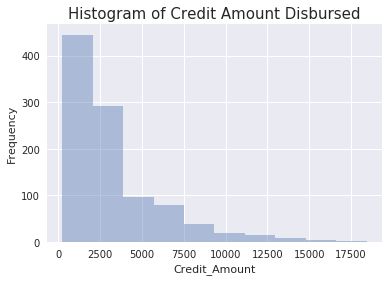

In [29]:
sn.distplot(csvPandas.Credit_Amount, kde = False,bins=10 )
plt.title( "Histogram of Credit Amount Disbursed", fontsize = 15)
plt.ylabel( "Frequency")

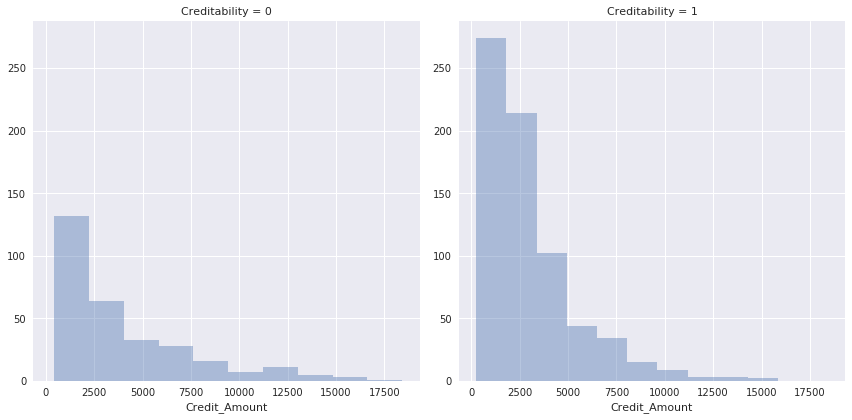

In [30]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Credit_Amount", kde = False, bins = 10 )

Text(0,0.5,'Frequency')

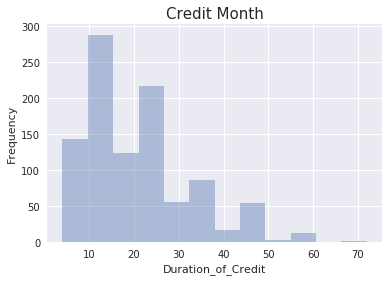

In [31]:
sn.distplot(csvPandas.Duration_of_Credit, kde = False,bins=12)
plt.title( "Credit Month", fontsize = 15)
plt.ylabel( "Frequency")

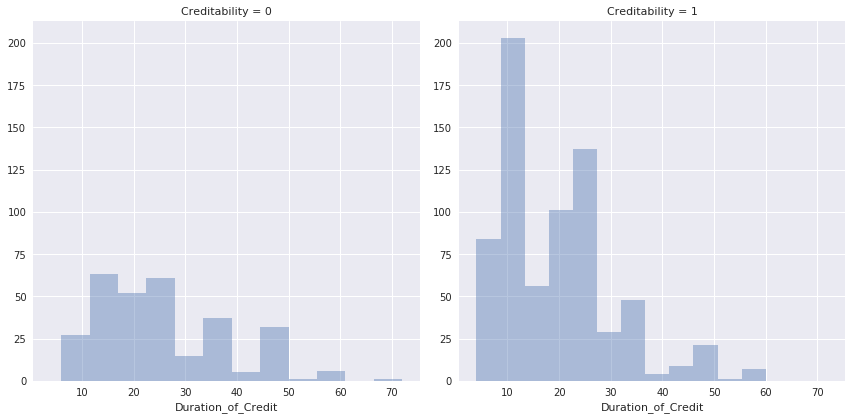

In [32]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Duration_of_Credit", kde = False, bins = 12)

Text(0,0.5,'Frequency')

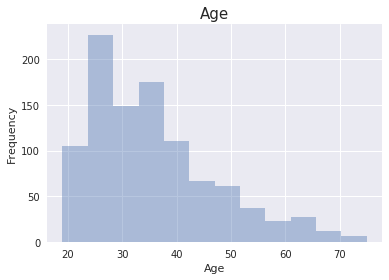

In [33]:
sn.distplot(csvPandas.Age, kde = False,bins=12)
plt.title( "Age", fontsize = 15)
plt.ylabel( "Frequency")

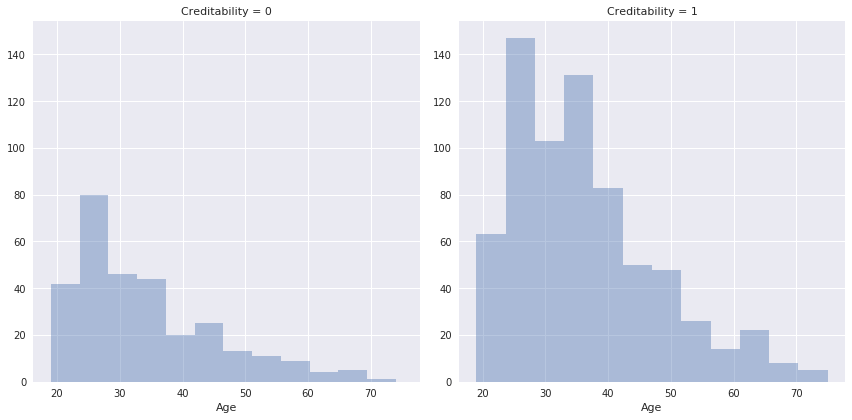

In [34]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Age", kde = False, bins = 12)

### Data classification using groupby class

In [35]:
csvDF.select("Creditability").groupBy("Creditability").count().show()

+-------------+-----+
|Creditability|count|
+-------------+-----+
|            0|  300|
|            1|  700|
+-------------+-----+



### Interquartile Range calculation by using pandas quantile method

In [36]:
rows=[]
rows.append((csvPandas['Credit_Amount'].min(),csvPandas.Credit_Amount.quantile(.25),csvPandas['Credit_Amount'].median(),csvPandas['Credit_Amount'].mean(),csvPandas.Credit_Amount.quantile(.75),csvPandas['Credit_Amount'].max()))
crAmountPerc = pd.DataFrame(rows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
crAmountPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,250,1365.5,2319.5,3271.248,3972.25,18424


In [37]:
dcrows=[]
dcrows.append((csvPandas['Duration_of_Credit'].min(),csvPandas.Duration_of_Credit.quantile(.25),csvPandas['Duration_of_Credit'].median(),csvPandas['Duration_of_Credit'].mean(),csvPandas.Duration_of_Credit.quantile(.75),csvPandas['Duration_of_Credit'].max()))
dcPerc = pd.DataFrame(dcrows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
dcPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,4,12.0,18.0,20.903,24.0,72


In [38]:
Agerows=[]
Agerows.append((csvPandas['Age'].min(),csvPandas.Age.quantile(.25),csvPandas['Age'].median(),csvPandas['Age'].mean(),csvPandas.Age.quantile(.75),csvPandas['Age'].max()))
agePerc = pd.DataFrame(Agerows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
agePerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,19,27.0,33.0,35.542,42.0,75


### Pearson’s Chi-squared test by using ChiSquareTest.test method

In [39]:
data=csvDF.rdd.map(lambda x:(Vectors.dense(x[1:]), float(x[0]))).toDF(["features", "label"])

In [40]:
r = ChiSquareTest.test(data, "features", "label").head()

In [41]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'PValues':r.pValues.values,'Chi^2':r.statistics.values,'D.F':r.degreesOfFreedom})
pdf.head(21)

,All,Chi^2,D.F,PValues
0,Account_Balance,123.720944,3,0.000000e+00
1,Duration_of_Credit,78.886937,32,7.784572e-06
2,Previous_Credit,61.691397,4,1.279199e-12
3,Purpose,33.356447,9,1.157491e-04
4,Credit_Amount,931.746032,922,4.045155e-01
5,Value_Savings_Stocks,36.098928,4,2.761214e-07
6,employment,18.368274,4,1.045452e-03
7,Instalment_percent,5.476792,3,1.400333e-01
8,Sex_MaritalStatus,9.605214,3,2.223801e-02
9,Guarantors,6.645367,2,3.605595e-02


### Convert data frame to feature and lable for further analysis

In [42]:
dataPanda = data.toPandas()
dataPanda.head(5)

,features,label
0,"[1.0, 18.0, 4.0, 2.0, 1049.0, 1.0, 2.0, 4.0, 2...",1.0
1,"[1.0, 9.0, 4.0, 0.0, 2799.0, 1.0, 3.0, 2.0, 3....",1.0
2,"[2.0, 12.0, 2.0, 9.0, 841.0, 2.0, 4.0, 2.0, 2....",1.0
3,"[1.0, 12.0, 4.0, 0.0, 2122.0, 1.0, 3.0, 3.0, 3...",1.0
4,"[1.0, 12.0, 4.0, 0.0, 2171.0, 1.0, 3.0, 4.0, 3...",1.0


In [43]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Decision Tree

### Creating Decision Tree Models

In [44]:
dtEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

### Decision Tree with maxDepth None 

In [45]:
dt1 = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=None)
dtModel1=dt1.fit(trainingData)
dtPredictions1=dtModel1.transform(testData)
dtEvaluator.evaluate(dtPredictions1)

0.6816608996539792

In [46]:
print("Bins :",dt1.getMaxBins())
print("Depth :",dt1.getMaxDepth())

Bins : 32
Depth : None


### Decision Tree after adjusting the attribute values

In [47]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=6,maxBins=20)

In [48]:
dtModel=dt.fit(trainingData)
dtPredictions=dtModel.transform(testData)
dtEvaluator.evaluate(dtPredictions)

0.7024221453287197

In [49]:
print("Bins :",dt.getMaxBins())
print("Depth :",dt.getMaxDepth())

Bins : 20
Depth : 6


### Prediction output of Decision Tree with attribute values

In [50]:
dtPredictionsPanda = dtPredictions.toPandas()
dtPredictionsPanda.head(5)

,features,label,rawPrediction,probability,prediction
0,"[1.0, 6.0, 1.0, 6.0, 1198.0, 1.0, 5.0, 4.0, 2....",0.0,"[36.0, 53.0]","[0.404494382022, 0.595505617978]",1.0
1,"[1.0, 6.0, 2.0, 2.0, 428.0, 1.0, 5.0, 2.0, 2.0...",1.0,"[36.0, 53.0]","[0.404494382022, 0.595505617978]",1.0
2,"[1.0, 6.0, 2.0, 3.0, 2647.0, 3.0, 3.0, 2.0, 3....",1.0,"[0.0, 15.0]","[0.0, 1.0]",1.0
3,"[1.0, 6.0, 2.0, 6.0, 448.0, 1.0, 2.0, 4.0, 2.0...",0.0,"[36.0, 53.0]","[0.404494382022, 0.595505617978]",1.0
4,"[1.0, 6.0, 4.0, 0.0, 1361.0, 1.0, 2.0, 2.0, 3....",1.0,"[0.0, 17.0]","[0.0, 1.0]",1.0


### Prediction Matrix
* 0.0 -> Bad
* 1.0 -> Good

In [51]:
dtMetricsData = dtPredictions.select("label","prediction")
pandaDtMetrics=dtMetricsData.groupby("label","prediction").count().toPandas()
pivotedDt = pandaDtMetrics.pivot(index='label', columns='prediction', values='count')
pivotedDt.head(5)

prediction,0.0,1.0
label,,
0.0,32,60
1.0,26,171


In [52]:
dtPenalty=pivotedDt.values[0][1]*5+pivotedDt.values[1][0]
print("Penalty of the matrix",dtPenalty)

Penalty of the matrix 326


# Random Forest

### Random Forest with Default Settings 

In [53]:
dfEvaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [54]:
rf1 = RandomForestClassifier(labelCol="label", featuresCol="features")
rfModel1 = rf1.fit(trainingData)
rfPredictions= rfModel1.transform(testData)

In [55]:
print("number of Classes :"+str(rfModel1.numClasses))

number of Classes :2


In [56]:
print("number of Features :"+str(rfModel1.numFeatures))

number of Features :20


In [57]:
print("Total number of Nodes :"+str(rfModel1.totalNumNodes))

Total number of Nodes :1026


In [58]:
print ("Max Bins",rf1.getMaxBins())

print ("Max Trees",rf1.getNumTrees())
print ("Max Depth",rf1.getMaxDepth())

Max Bins 32
Max Trees 20
Max Depth 5


In [59]:
dfEvaluator1.evaluate(rfPredictions)

0.726643598615917

### Tuning Random Forest with cross-validator

In [60]:
rfEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [61]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [62]:
paramGridRf = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [10, 20])
             .addGrid(rf.numTrees, [10,20,100])
             .build())

In [63]:
rfCv = CrossValidator(estimator=rf, estimatorParamMaps=paramGridRf, evaluator=rfEvaluator, numFolds=2)

In [64]:
rfCvModel = rfCv.fit(trainingData)

In [65]:
rfPredictions = rfCvModel.transform(testData)

In [66]:
rfEvaluator.evaluate(rfPredictions)

0.7335640138408305

In [67]:
print("Max Trees",rfCvModel.bestModel.getNumTrees)

Max Trees 100


In [68]:
bestModel = rfCvModel.bestModel
finalPredictions = bestModel.transform(data)
rfEvaluator.evaluate(finalPredictions)

0.836

In [69]:
rfPredictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,6.0,1.0,6.0,...|  0.0|[52.2520275963571...|[0.52252027596357...|       0.0|
|[1.0,6.0,2.0,2.0,...|  1.0|[37.9083363854564...|[0.37908336385456...|       1.0|
|[1.0,6.0,2.0,3.0,...|  1.0|[16.3298507753985...|[0.16329850775398...|       1.0|
|[1.0,6.0,2.0,6.0,...|  0.0|[47.9019354656708...|[0.47901935465670...|       1.0|
|[1.0,6.0,4.0,0.0,...|  1.0|[12.3222963001596...|[0.12322296300159...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [70]:
metricsData = rfPredictions.select("label","prediction")
sDF=metricsData.groupby("label","prediction").count()
pandaSDF=sDF.toPandas()
df2 = pandaSDF.pivot(index='label', columns='prediction', values='count')
df2.head(5)

prediction,0.0,1.0
label,,
0.0,24,68
1.0,9,188


In [71]:
penalty=df2.values[0][1]*5+df2.values[1][0]
print(penalty)

349


### Feature Importance for Random Forest

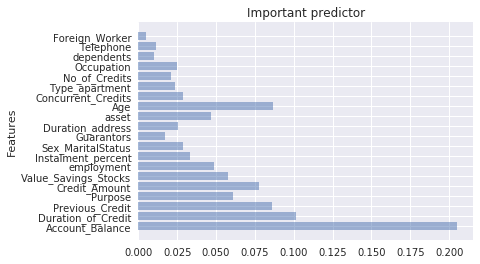

In [72]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'Important':bestModel.featureImportances.values},columns=['All','Important'])
objects = csvDF.columns[1:]
y_pos = np.arange(len(csvDF.columns[1:]))
performance = bestModel.featureImportances.values
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Features')
plt.title('Important predictor')

plt.show()


## Results Comparison

* Pre-determined values for baseline models are below.

* Accuracy of Baseline Model 1 is 0.7
* Accuracy of Baseline Model 2 is 0.3
* Penalty of Baseline Model 1 is 450
* Penalty of Baseline Model 1 is 210

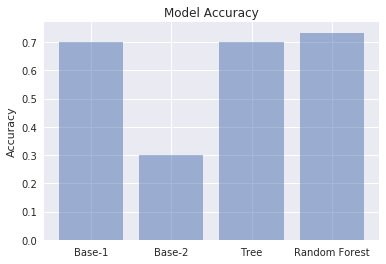

In [73]:
objects = ('Base-1', 'Base-2', 'Tree', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [.7,.3,dtEvaluator.evaluate(dtPredictions),rfEvaluator.evaluate(rfPredictions)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
 
plt.show()

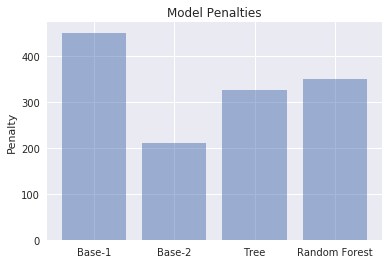

In [74]:
objects = ('Base-1', 'Base-2', 'Tree', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [450,210,dtPenalty,penalty]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Penalty')
plt.title('Model Penalties')
 
plt.show()

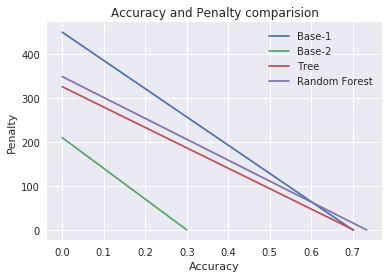

In [75]:

datax1=[.7,.3,dtEvaluator.evaluate(dtPredictions),rfEvaluator.evaluate(rfPredictions)]
datay1=[0,0,0,0]

datax2=[0,0,0,0]
datay2=[450,210,dtPenalty,penalty]
models =['Base-1','Base-2','Tree','Random Forest']

fig,ax = plt.subplots()
for i in range(len(datax1)):
    x = (datax1[i], datax2[i])
    y = (datay1[i], datay2[i]) 
    ax.plot(x, y,label=models[i])
ax.legend()
plt.title("Accuracy and Penalty comparision")
plt.xlabel("Accuracy")
plt.ylabel("Penalty")
plt.show()

